In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import gensim
import nltk
from gensim.models.word2vec import Word2Vec
import tensorflow as tf
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
import re
import matplotlib.pyplot as plt

Using TensorFlow backend.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-pa

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read the file
df3 = pd.read_csv('data/Reduced_Cleaned_Reviews.csv')


In [3]:
df3['rating_class'] = df3['user_sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)
X = df3['clean_text']
y = df3['rating_class']

In [4]:
df3['clean_text'][:5]

0    awesome love album good hip hop side current p...
1       good good flavor review collect part promotion
2    disappoint read review look buy one couple lub...
3    irritation husband buy gel us gel cause irrita...
4    not worth boyfriend buy spice things bedroom h...
Name: clean_text, dtype: object

## Tokenizer

In [5]:
from keras.preprocessing.text import Tokenizer

samples = X
tokenizer = Tokenizer(lower=True, split=' ') # creates tokenizer
tokenizer.fit_on_texts(samples)  # builds the word index
sequences = tokenizer.texts_to_sequences(samples) #turns strings into list of integers
# word_index is a dictionary mapping words to an integer index
word_index = tokenizer.word_index 
print(f'Found {len(word_index)} unique tokens. ')

Found 9226 unique tokens. 


In [6]:
max([max(sequence) for sequence in sequences])

9226

In [7]:
# Each number is the index of the word in the order of word in original text
sequences[0]

[37,
 3,
 766,
 14,
 4457,
 722,
 424,
 1717,
 750,
 708,
 4458,
 1432,
 105,
 1522,
 128,
 394,
 1040,
 67,
 4459,
 574]

In [8]:
word_index

{'use': 1,
 'great': 2,
 'love': 3,
 'part': 4,
 'review': 5,
 'collect': 6,
 'promotion': 7,
 'wipe': 8,
 'clean': 9,
 'product': 10,
 'clorox': 11,
 'movie': 12,
 'easy': 13,
 'good': 14,
 'disinfect': 15,
 'smell': 16,
 'not': 17,
 'like': 18,
 'make': 19,
 'work': 20,
 'one': 21,
 'get': 22,
 'keep': 23,
 'best': 24,
 'house': 25,
 'time': 26,
 'kitchen': 27,
 'convenient': 28,
 'bathroom': 29,
 'products': 30,
 'quick': 31,
 'really': 32,
 'funny': 33,
 'go': 34,
 'always': 35,
 'well': 36,
 'awesome': 37,
 'buy': 38,
 'feel': 39,
 'home': 40,
 'everything': 41,
 'would': 42,
 'kid': 43,
 'movies': 44,
 'mess': 45,
 'germs': 46,
 'know': 47,
 'leave': 48,
 'recommend': 49,
 'also': 50,
 'every': 51,
 'skin': 52,
 'price': 53,
 'watch': 54,
 'need': 55,
 'job': 56,
 'first': 57,
 'look': 58,
 'around': 59,
 'fresh': 60,
 'scent': 61,
 'no': 62,
 'counter': 63,
 'family': 64,
 'better': 65,
 'help': 66,
 'way': 67,
 'years': 68,
 'surface': 69,
 'excellent': 70,
 'much': 71,
 'dont'

In [9]:
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sequences[0]])

In [10]:
def sequence_to_text(sequence):
    words =  [reverse_word_index.get(letter) for letter in sequence]
    return words

my_text = list(map(sequence_to_text, sequences))

In [11]:
print(sequences[0])

[37, 3, 766, 14, 4457, 722, 424, 1717, 750, 708, 4458, 1432, 105, 1522, 128, 394, 1040, 67, 4459, 574]


## Word2Vec and Simple Neural Network

In [12]:
word2vec = gensim.models.Word2Vec(my_text,
                                  size=100,
                                  window=10,
                                  min_count=1)
word2vec.train(my_text, total_examples=25026, epochs=10)

(1673973, 2427570)

In [13]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['feel', 'good', 'product', 'cheap', 'junk', 'bad', 'great','price','love']}
similar_words

{'feel': ['tacky', 'soft', 'radiant', 'condioner', 'foundation'],
 'good': ['great', 'fragnense', 'fetch', 'doesgreat', 'natureand'],
 'product': ['anyones', 'brazen', 'pomade', 'actorswas', 'recapture'],
 'cheap': ['caution', 'marshall', 'blu', 'low', 'black'],
 'junk': ['direct', 'upset', 'hat', 'pluck', 'careful'],
 'bad': ['might', 'didnt', 'ugh', 'thats', 'usually'],
 'great': ['excellent', 'good', 'awesome', 'multi', 'upsthey'],
 'price': ['deal', 'nicety', 'ray', 'storeshad', 'blu'],
 'love': ['awesome', 'lemons', 'practically', 'favorite', 'awesom']}

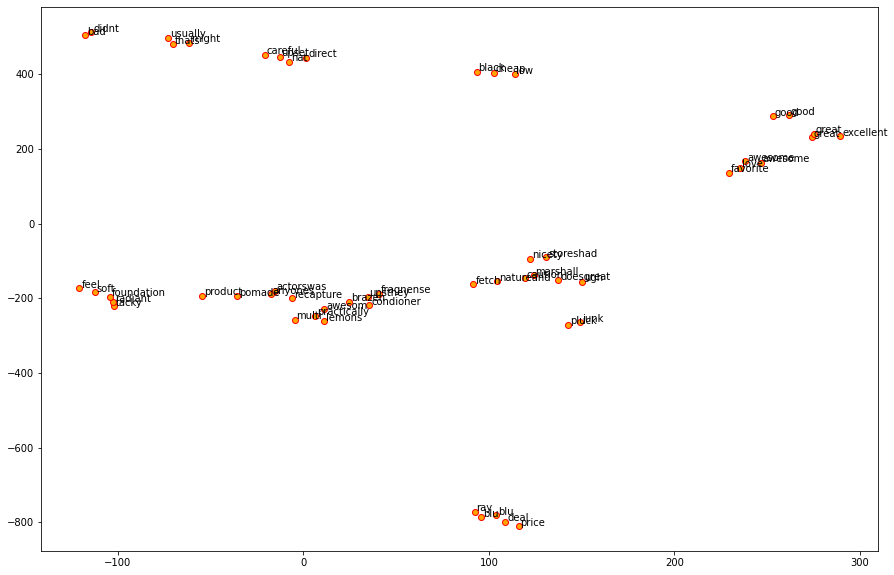

In [14]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(15, 10))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

In [15]:
len(word_index.keys())

9226

In [16]:
len(word2vec.wv.vocab)

9226

So we created word vectors using Word2Vec and the model has 9226 unique words where each word has a vector length of 100

Now we are going to use these dense vectors - word embeddings - in a simple neural network to predict

In [17]:
from keras.preprocessing.sequence import pad_sequences
max_length = 200 # fix the length of each review 
max_words = len(word_index.keys()) # fix number of words 

training_samples = 6000
validation_samples = 2933
data = pad_sequences(sequences, maxlen=max_length)

#labels = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

x_train = data[:training_samples]
y_train = y[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = y[training_samples: training_samples + validation_samples]
print('Shape of training data: ', x_train.shape)
print('Shape of validation data: ', x_val.shape)

Shape of data tensor: (15000, 200)
Shape of label tensor: (15000,)
Shape of training data:  (6000, 200)
Shape of validation data:  (2933, 200)


In [18]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words+1, embedding_dim))
for word , i in word_index.items():
    embedding_vector = word2vec.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(9227, 100)

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


model = Sequential()
model.add(Embedding(max_words+1, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          922700    
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,562,765
Trainable params: 1,562,765
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 6000 samples, validate on 2933 samples
Epoch 1/10
6000/6000 [==============================] - 3s 481us/step - loss: 0.4275 - acc: 0.8627 - val_loss: 0.3631 - val_acc: 0.9018
Epoch 2/10
6000/6000 [==============================] - 2s 362us/step - loss: 0.3820 - acc: 0.8653 - val_loss: 0.3507 - val_acc: 0.9018
Epoch 3/10
6000/6000 [==============================] - 2s 357us/step - loss: 0.3579 - acc: 0.8662 - val_loss: 0.3549 - val_acc: 0.9021
Epoch 4/10
6000/6000 [==============================] - 2s 354us/step - loss: 0.3322 - acc: 0.8698 - val_loss: 0.3785 - val_acc: 0.9008
Epoch 5/10
6000/6000 [==============================] - 2s 350us/step - loss: 0.3089 - acc: 0.8800 - val_loss: 0.3879 - val_acc: 0.8933
Epoch 6/10
6000/6000 [==============================] - 2s 355us/step - loss: 0.2808 - acc: 0.8893 - val_loss: 0.4041 - val_acc: 0.8981
Epoch 7/10
6000/6000 [==============================] - 2s 362us/step - loss: 0.2563 - acc: 0.8973 - val_loss: 0.4373 - val_acc: 0.8902


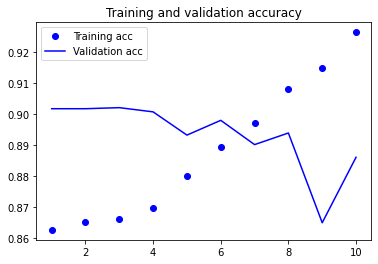

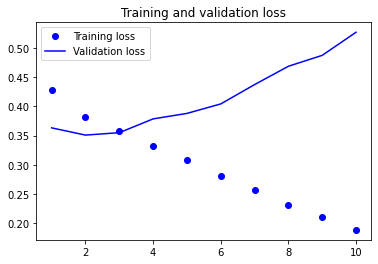

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()